Yonatan Juarez
CS677

In [1]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os
from PIL import Image
from io import BytesIO
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import tarfile
from tarfile import open

In [2]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch


In [3]:
from google.colab import drive
drive.mount('/content/drive')
# import os
# os.chdir('path/to/zip/file/')
# !tar -xzvf CINIC-10.tar.gz

Mounted at /content/drive


In [4]:

tar = open("/content/drive/MyDrive/Fall2024/CINIC-10.tar.gz", "r:gz")
tar.extractall()
  # tar
# tar.close()

In [5]:
from tqdm import tqdm

<font size=5> Dataset

In [6]:
class CINIC10Dataset:
  def __init__(self, batch_size=64, root='.'):
    # self.transform = transforms.Compose([
    #         transforms.Resize((32, 32)),  # Adjust size as needed
    #         transforms.ToTensor(),
    #         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Adjust normalization values
    #     ])
    initial_transform = transforms.Compose([
          transforms.Resize((32, 32)),
          transforms.ToTensor()
      ])
    self.batch_size = batch_size

    temp_dataset = datasets.ImageFolder(root=f"{root}/train", transform=initial_transform)
    temp_loader = DataLoader(temp_dataset, batch_size=batch_size, shuffle=False)

    # Calculate mean and std
    mean, std = self.calculate_mean_std(temp_loader)

     # Define transformations with calculated mean and std
    self.transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    # initialize dataset and data loaders
    self.train_dataset = datasets.ImageFolder(root=f"./train", transform=self.transform)
    self.train_dataloader = DataLoader(self.train_dataset , batch_size=batch_size , \
                                       shuffle=True, num_workers=2)

    self.valid_dataset = datasets.ImageFolder(root=f"./valid", transform=self.transform)
    self.valid_dataloader = DataLoader(self.valid_dataset , batch_size=batch_size , \
                                       shuffle=True, num_workers=2)

    self.test_dataset = datasets.ImageFolder(root=f"./test", transform=self.transform)
    self.test_dataloader = DataLoader(self.test_dataset , batch_size=batch_size , \
                                      shuffle=True, num_workers=2)

  #  You should normalize the images to zero mean and unit variance for pre-processing.
  # First normalize your image pixel values to (0,1) range, calculate the dataset mean/std values,
  # and then normalize the images to be zero mean and unit variance.
  def calculate_mean_std(self, loader):
        # Calculate mean and std across all batches in the loader
        mean = 0.0
        std = 0.0
        total_images_count = 0
        for images, _ in loader:
            batch_samples = images.size(0)  # batch size (the last batch can have smaller size)
            images = images.view(batch_samples, images.size(1), -1)  # flatten each channel
            mean += images.mean(2).sum(0)
            std += images.std(2).sum(0)
            total_images_count += batch_samples

        mean /= total_images_count
        std /= total_images_count
        return mean, std



In [ ]:
# load data in memory using tar
# tar = open("/content/drive/MyDrive/Fall2024/CINIC-10.tar.gz", "r:gz")
# tar.extractall()


In [ ]:
# tar_path = "/content/drive/MyDrive/Fall2024/CINIC-10.tar.gz"
# cinic10_dataloader = CINIC10DataLoader(tar_path, batch_size=64)

In [ ]:
# mean, std = calculate_mean_std(tar_path)
# cinic10_loader = CINIC10DataLoader(tar_path=tar_path, batch_size=64, mean=mean, std=std)

<font size=5>TRAINING

In [ ]:
# Train the networks using the given training data for 20 epochs. For the main experiment setting,
# we suggest starting with a mini-batch size of 128, ADAM optimizer with learning rate α = 0.001,
# β1 = 0.9 and β2 = 0.999. You are free to experiment with other learning rates and other optimizers.
# Please use cross entropy loss for your main experiment. Record the error after each step (i.e. after each batch)
# so you can monitor it and plot it to show results. During training, you should test on the validation set
# at some regular intervals; say every 5 epochs, to check whether the model is overfitting.
# Note: To plot the loss function or accuracy, you can use pylab, matplotlib or tensorboard to show the curve.

In [16]:
epochs = 20
mini_batch_size = 128
learning_rate = 0.001
beta1 = 0.9
beta2 = 0.999

In [8]:
class LeNet5(nn.Module):
  def __init__(self):
    super(LeNet5, self).__init__()
    self.conv1 = nn.Conv2d(3, 6, kernel_size=5)  # 1 input channel for grayscale
    self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
    self.fc1 = nn.Linear(16 * 5 * 5, 120)  # Flatten to 120
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)  # 10 classes i.e num_classes = 10

    # Define the ReLU activation function
    self.relu = nn.ReLU()

  def forward(self, x):
    x = F.relu(self.conv1(x))  # Apply ReLU after conv1
    x = F.avg_pool2d(x, 2)  # Average pooling
    x = F.relu(self.conv2(x))  # Apply ReLU after conv2
    x = F.avg_pool2d(x, 2)  # Average pooling
    x = x.view(x.size(0), -1)  # Flatten
    x = F.relu(self.fc1(x))  # Apply ReLU after fc1
    x = F.relu(self.fc2(x))  # Apply ReLU after fc2
    x = self.fc3(x)  # Output layer (no ReLU here)
    return x


In [9]:
dataloader = CINIC10Dataset(batch_size=mini_batch_size)


In [ ]:
model = LeNet5()
# define loss function & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(beta1, beta2))

In [ ]:
# L2-regularization
model = LeNet5()
criterion = nn.CrossEntropyLoss()
conv_params = []
fc_params = []
for name, param in model.named_parameters():
    if 'conv' in name: # apply regularization to conv layers
        conv_params.append(param)
    else: # apply regularization to fully connected layers
        fc_params.append(param)
optimizer = optim.Adam([
    { 'params':conv_params, 'weight_decay':0.0001 }, #l2-reg for conv layers
    { 'params':fc_params , 'weight_decay': 0.001},  # stronger l2 reg for fully connected layers
], lr=learning_rate, betas=(beta1, beta2))

In [26]:
# Lists to store losses for plotting later
train_losses = []
train_accuracies = []
# val_accuracies = []
# val_losses = []

batch_losses = []
validation_losses = []
validation_accuracies = []

In [ ]:
for epoch in tqdm(range(epochs)):
    model.train( )  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    print(f"Starting epoch {epoch + 1}/{epochs}")
    for i, data in enumerate(dataloader.train_dataloader,0):
      inputs, labels = data
      optimizer.zero_grad()  # Zero the gradients
      outputs = model(inputs)  # Forward pass

      loss = criterion(outputs, labels)  # Calculate loss
      loss.backward()  # Backward pass
      optimizer.step()  # Update weights

      # Accumulate loss and accuracy metrics
      running_loss += loss.item() * inputs.size(0)
      batch_losses.append(loss.item())  # Track batch loss

      # Calculate batch accuracy
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

      # # Print batch progress every 100 batches
      # if (i + 1) % 100 == 0:
      #     print(f"Epoch [{epoch + 1}], Batch [{i + 1}], Batch Loss: {loss.item():.4f}")

      # add validation step every 100
      # model.eval

    # Epoch lossand accuracy
    epoch_loss = running_loss / total
    epoch_accuracy = correct / total

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    print(f'Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

    # Validation Step every 5 epochs
    if (epoch + 1) % 5 == 0:
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():  # Disable gradient calculation for validation
            for val_inputs, val_labels in dataloader.valid_dataloader:
                val_outputs = model(val_inputs)
                val_batch_loss = criterion(val_outputs, val_labels)
                val_loss += val_batch_loss.item() * val_inputs.size(0)

                _, val_predicted = torch.max(val_outputs.data, 1)
                val_total += val_labels.size(0)
                val_correct += (val_predicted == val_labels).sum().item()

        # Calculate validation metrics
        val_loss /= val_total
        val_accuracy = val_correct / val_total
        validation_losses.append(val_loss)
        validation_accuracies.append(val_accuracy)

        print(f'\tValidation after Epoch [{epoch + 1}]: Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}')

    model.train()  # Set back to training mode after validation
print("Finished training")


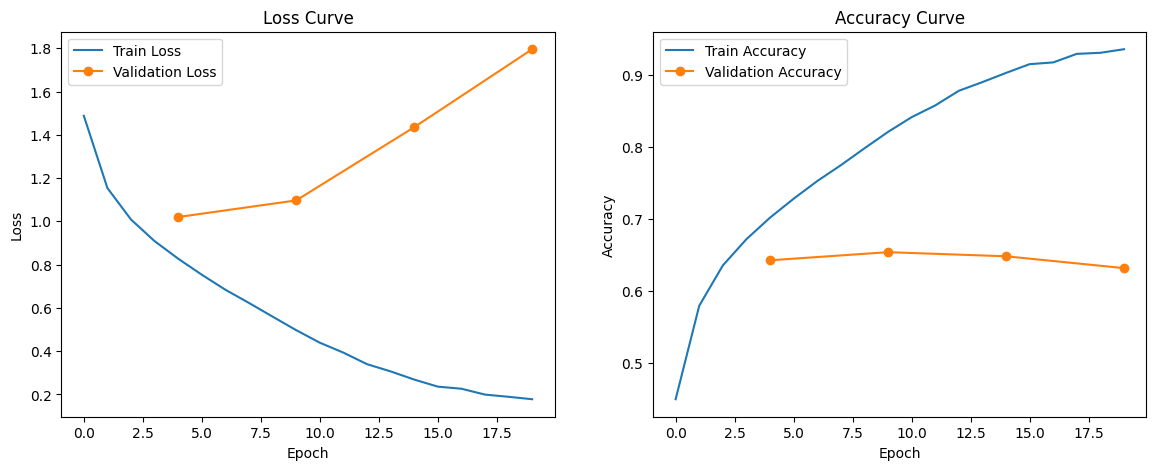

In [31]:

# Plotting loss and accuracy
plt.figure(figsize=(14, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(range(4, len(train_losses), 5), validation_losses, label="Validation Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(range(4, len(train_accuracies), 5), validation_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curve")
plt.legend()

plt.show()

In [ ]:
# Set the model to evaluation mode
model.eval()

test_correct = 0
test_total = 0
# Lists to hold true labels and predictions
all_preds = []
all_labels = []

with torch.no_grad():  # Disable gradient calculations for testing
    for inputs, labels in dataloader.test_dataloader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

        # Store predictions and labels
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert lists to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)


test_accuracy = test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.4f}")

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=dataloader.test_dataset.classes, yticklabels=dataloader.test_dataset.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print classification report for per-class accuracy and other metrics
print(classification_report(all_labels, all_preds, target_names=dataloader.test_dataset.classes))

<font size=5>ResNet-9 network

In [27]:
# Define a basic residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        # Define two convolutional layers with BatchNorm and ReLU activations
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Define a shortcut to match input/output dimensions if necessary
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, padding=0),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        # Pass the input through the convolution layers and the shortcut
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)  # Add the input (residual connection)
        out = F.relu(out)  # Final ReLU activation
        return out


# Define the ResNet-9 model
class ResNet9(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet9, self).__init__()

        # Initial convolution layer
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)  # 3 input channels (RGB), 16 output channels
        self.bn1 = nn.BatchNorm2d(16)

        # Define residual blocks
        self.block1 = ResidualBlock(16, 16, stride=1)
        self.block2 = ResidualBlock(16, 32, stride=2)
        self.block3 = ResidualBlock(32, 64, stride=2)
        self.block4 = ResidualBlock(64, 64, stride=1)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 8 * 8, 256)  # Assuming 32x32 input images
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        # Initial convolution and batch norm
        x = F.relu(self.bn1(self.conv1(x)))

        # Pass through the residual blocks
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)

        # Flatten the output of the last block and pass through fully connected layers
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # Output layer

        return x

In [28]:
model = ResNet9(num_classes=10)

# Set device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.0001, betas=(beta1, beta2))
# optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(beta1, beta2))

criterion = nn.CrossEntropyLoss()

In [29]:
for epoch in tqdm(range(epochs)):
    model.train( )  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    print(f"Starting epoch {epoch + 1}/{epochs}")
    for i, data in enumerate(dataloader.train_dataloader,0):
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)
      optimizer.zero_grad()  # Zero the gradients
      outputs = model(inputs)  # Forward pass

      loss = criterion(outputs, labels)  # Calculate loss
      loss.backward()  # Backward pass
      optimizer.step()  # Update weights

      # Accumulate loss and accuracy metrics
      running_loss += loss.item() * inputs.size(0)
      batch_losses.append(loss.item())  # Track batch loss

      # Calculate batch accuracy
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

      # # Print batch progress every 100 batches
      # if (i + 1) % 100 == 0:
      #     print(f"Epoch [{epoch + 1}], Batch [{i + 1}], Batch Loss: {loss.item():.4f}")

      # add validation step every 100
      # model.eval

    # Epoch lossand accuracy
    epoch_loss = running_loss / total
    epoch_accuracy = correct / total

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    print(f'Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

    # Validation Step every 5 epochs
    if (epoch + 1) % 5 == 0:
        model.eval()  # Set model to evaluation mode
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():  # Disable gradient calculation for validation
            for val_inputs, val_labels in dataloader.valid_dataloader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = model(val_inputs)
                val_batch_loss = criterion(val_outputs, val_labels)
                val_loss += val_batch_loss.item() * val_inputs.size(0)

                _, val_predicted = torch.max(val_outputs.data, 1)
                val_total += val_labels.size(0)
                val_correct += (val_predicted == val_labels).sum().item()

        # Calculate validation metrics
        val_loss /= val_total
        val_accuracy = val_correct / val_total
        validation_losses.append(val_loss)
        validation_accuracies.append(val_accuracy)

        print(f'\tValidation after Epoch [{epoch + 1}]: Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}')

    model.train()  # Set back to training mode after validation
print("Finished training")


  0%|          | 0/20 [00:00<?, ?it/s]

Starting epoch 1/20


  5%|▌         | 1/20 [00:45<14:28, 45.69s/it]

Epoch [1/20], Loss: 1.4881, Accuracy: 0.4498
Starting epoch 2/20


 10%|█         | 2/20 [01:29<13:23, 44.65s/it]

Epoch [2/20], Loss: 1.1538, Accuracy: 0.5797
Starting epoch 3/20


 15%|█▌        | 3/20 [02:13<12:36, 44.49s/it]

Epoch [3/20], Loss: 1.0084, Accuracy: 0.6357
Starting epoch 4/20


 20%|██        | 4/20 [02:59<11:56, 44.78s/it]

Epoch [4/20], Loss: 0.9086, Accuracy: 0.6722
Starting epoch 5/20
Epoch [5/20], Loss: 0.8274, Accuracy: 0.7021


 25%|██▌       | 5/20 [04:21<14:35, 58.35s/it]

	Validation after Epoch [5]: Loss: 1.0201, Accuracy: 0.6428
Starting epoch 6/20


 30%|███       | 6/20 [05:04<12:23, 53.13s/it]

Epoch [6/20], Loss: 0.7533, Accuracy: 0.7284
Starting epoch 7/20


 35%|███▌      | 7/20 [05:48<10:50, 50.05s/it]

Epoch [7/20], Loss: 0.6839, Accuracy: 0.7529
Starting epoch 8/20


 40%|████      | 8/20 [06:33<09:42, 48.52s/it]

Epoch [8/20], Loss: 0.6228, Accuracy: 0.7749
Starting epoch 9/20


 45%|████▌     | 9/20 [07:17<08:38, 47.18s/it]

Epoch [9/20], Loss: 0.5597, Accuracy: 0.7984
Starting epoch 10/20
Epoch [10/20], Loss: 0.4970, Accuracy: 0.8212


 50%|█████     | 10/20 [08:40<09:42, 58.23s/it]

	Validation after Epoch [10]: Loss: 1.0969, Accuracy: 0.6541
Starting epoch 11/20


 55%|█████▌    | 11/20 [09:24<08:03, 53.69s/it]

Epoch [11/20], Loss: 0.4392, Accuracy: 0.8417
Starting epoch 12/20


 60%|██████    | 12/20 [10:09<06:49, 51.23s/it]

Epoch [12/20], Loss: 0.3932, Accuracy: 0.8580
Starting epoch 13/20


 65%|██████▌   | 13/20 [10:55<05:46, 49.55s/it]

Epoch [13/20], Loss: 0.3399, Accuracy: 0.8784
Starting epoch 14/20


 70%|███████   | 14/20 [11:40<04:48, 48.16s/it]

Epoch [14/20], Loss: 0.3065, Accuracy: 0.8904
Starting epoch 15/20
Epoch [15/20], Loss: 0.2687, Accuracy: 0.9032


 75%|███████▌  | 15/20 [13:05<04:56, 59.26s/it]

	Validation after Epoch [15]: Loss: 1.4352, Accuracy: 0.6484
Starting epoch 16/20


 80%|████████  | 16/20 [13:49<03:38, 54.73s/it]

Epoch [16/20], Loss: 0.2360, Accuracy: 0.9154
Starting epoch 17/20


 85%|████████▌ | 17/20 [14:33<02:34, 51.60s/it]

Epoch [17/20], Loss: 0.2264, Accuracy: 0.9178
Starting epoch 18/20


 90%|█████████ | 18/20 [15:19<01:39, 49.69s/it]

Epoch [18/20], Loss: 0.1993, Accuracy: 0.9297
Starting epoch 19/20


 95%|█████████▌| 19/20 [16:03<00:48, 48.08s/it]

Epoch [19/20], Loss: 0.1890, Accuracy: 0.9312
Starting epoch 20/20
Epoch [20/20], Loss: 0.1778, Accuracy: 0.9361


100%|██████████| 20/20 [17:25<00:00, 52.28s/it]

	Validation after Epoch [20]: Loss: 1.7957, Accuracy: 0.6320
Finished training


Test Accuracy: 0.6284


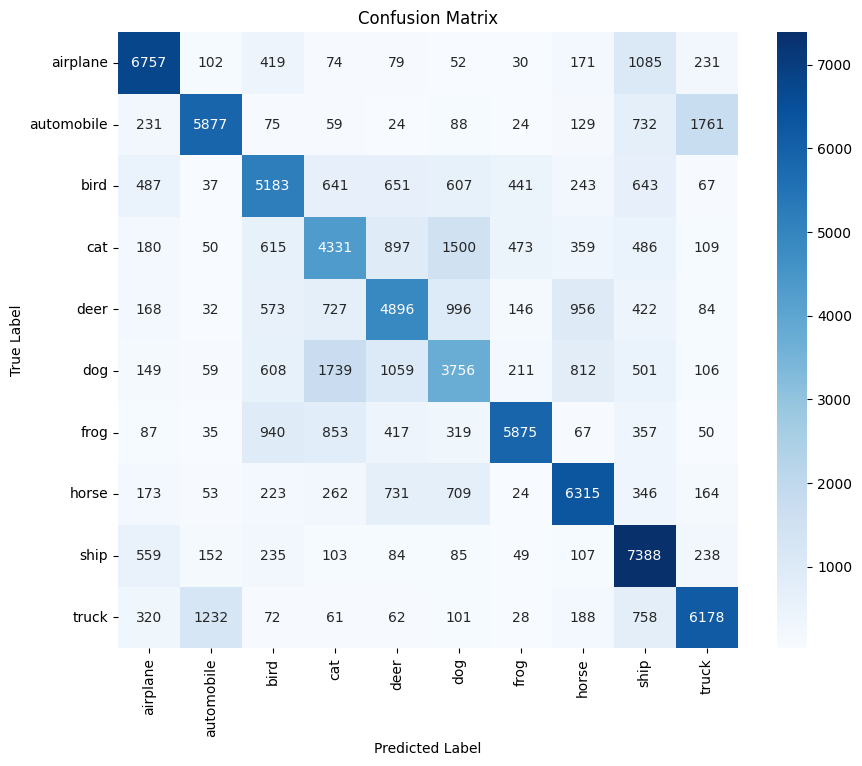

              precision    recall  f1-score   support

    airplane       0.74      0.75      0.75      9000
  automobile       0.77      0.65      0.71      9000
        bird       0.58      0.58      0.58      9000
         cat       0.49      0.48      0.49      9000
        deer       0.55      0.54      0.55      9000
         dog       0.46      0.42      0.44      9000
        frog       0.80      0.65      0.72      9000
       horse       0.68      0.70      0.69      9000
        ship       0.58      0.82      0.68      9000
       truck       0.69      0.69      0.69      9000

    accuracy                           0.63     90000
   macro avg       0.63      0.63      0.63     90000
weighted avg       0.63      0.63      0.63     90000



In [32]:
# Set the model to evaluation mode
model.eval()

test_correct = 0
test_total = 0
# Lists to hold true labels and predictions
all_preds = []
all_labels = []

with torch.no_grad():  # Disable gradient calculations for testing
    for inputs, labels in dataloader.test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

        # Store predictions and labels
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert lists to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)


test_accuracy = test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.4f}")

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=dataloader.test_dataset.classes, yticklabels=dataloader.test_dataset.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print classification report for per-class accuracy and other metrics
print(classification_report(all_labels, all_preds, target_names=dataloader.test_dataset.classes))